In [1]:
import pyfair

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [2]:
from pyfair.report.individual import FairReport
from pyfair.report.tree_graph import FairTreeGraph

In [3]:
model1 = pyfair.FairModel(name="HA", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model1.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model1.calculate_all()


#fr = FairReport(model1)
#fr.to_html('C:/Users/theon/Desktop/report.html')
results = model1.export_results()
node_statuses = model1.get_node_statuses()

In [4]:
results.T
rep = FairReport(model1)

[<matplotlib.patches.Rectangle object at 0x00000235F344F908>, <matplotlib.patches.Rectangle object at 0x00000235F344F9E8>, <matplotlib.patches.Rectangle object at 0x00000235F3480A90>, <matplotlib.patches.Rectangle object at 0x00000235F3480BA8>, <matplotlib.patches.Rectangle object at 0x00000235F3480CC0>, <matplotlib.patches.Rectangle object at 0x00000235F3480DD8>, <matplotlib.patches.Rectangle object at 0x00000235F3480EF0>, <matplotlib.patches.Rectangle object at 0x00000235F3488048>, <matplotlib.patches.Rectangle object at 0x00000235F3488160>, <matplotlib.patches.Rectangle object at 0x00000235F3488278>, <matplotlib.patches.Rectangle object at 0x00000235F3488390>, <matplotlib.patches.Rectangle object at 0x00000235F34884A8>, <matplotlib.patches.Rectangle object at 0x00000235F34885C0>, <matplotlib.patches.Rectangle object at 0x00000235F34886D8>, <matplotlib.patches.Rectangle object at 0x00000235F34887F0>]


,status,color,tag,self_x,self_y,parent_x,parent_y,μ,σ,↑,high,low,mode,formatter
Action,Not Required,grey,A,1200,0,600,800,NaN,NaN,NaN,NaN,NaN,NaN,{0:.2f}
Asset Loss Factors,Not Required,grey,ALF,4800,0,5400,800,NaN,NaN,NaN,NaN,NaN,NaN,"${0:,.2f}"
Contact,Not Required,grey,C,0,0,600,800,NaN,NaN,NaN,NaN,NaN,NaN,{0:.2f}
Control Strength,Not Required,grey,CS,3600,0,3000,800,NaN,NaN,NaN,NaN,NaN,NaN,{0:.2f}
External Loss Factors,Not Required,grey,ELF,8400,0,7800,800,NaN,NaN,NaN,NaN,NaN,NaN,"${0:,.2f}"
Loss Event Frequency,Supplied,green,LEF,1800,1600,4200,2400,2.174925e-01,8.113345e-02,4.623738e-01,0.5,0.01,0.2,{0:.2f}
Organizational Loss Factors,Not Required,grey,OLF,7200,0,7800,800,NaN,NaN,NaN,NaN,NaN,NaN,"${0:,.2f}"
Primary Loss Factors,Not Required,grey,PLF,5400,800,6600,1600,NaN,NaN,NaN,NaN,NaN,NaN,"${0:,.2f}"
Probable Loss Magnitude,Supplied,green,PLM,6600,1600,4200,2400,2.331760e+06,1.675184e+06,9.245129e+06,10000000,1,1000000,"${0:,.2f}"
Risk,Calculated,blue,R,4200,2400,4200,5000,5.052765e+05,4.288326e+05,2.784397e+06,NaN,NaN,NaN,"${0:,.2f}"


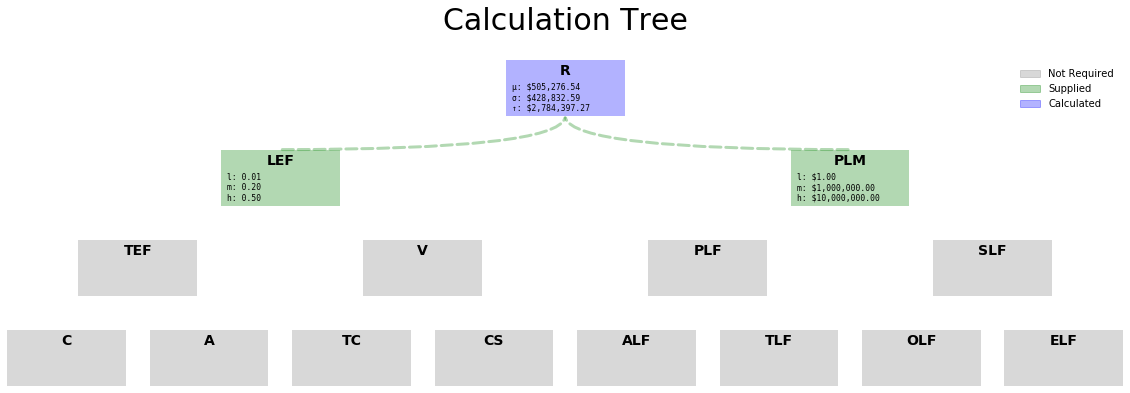

In [5]:
# Test
ftg = FairTreeGraph(
    model=model1,
    format_strings=rep.get_format_strings(),
)

ftg.generate_image()

ftg._data
# FAIR DISTRIBUTION VISUALIZER
# FAIR LOSS EXCEDENCE CURVE
# FAIR BREACH CURVE

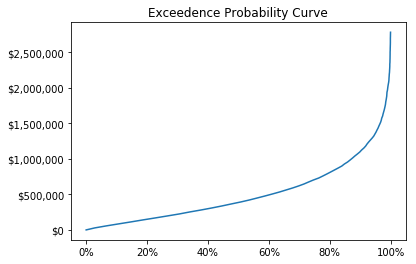

In [13]:
class FairProbabilityCurve(object):
    
    def __init__(self, model):
        self._model = model
        self._results = model.export_results()
        self._params = model.export_params()
        self._risk = self._results['Risk']

    def generate_image(self):
        fig, ax = plt.subplots()
        # Generate numbers
        risk_max = self._risk.max()
        risk_min = self._risk.min()
        space = np.linspace(0, risk_max, 100)
        series = pd.Series(space)
        # For each percentile, what is the expected loss?
        quantiles = series.map(lambda x: stats.percentileofscore(risk, x))
        ax = plt.plot(quantiles, series)[0]
        # Format axes
        ax.axes.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
        ax.axes.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))
        ax.axes.set_title('Exceedence Probability Curve')

class FairProbabilityComparison(object):
    pass

class FairLossCurve(object):
    pass

class FairLossComparison(object):
    pass


fpc = FairProbabilityCurve(model1)
fpc.generate_image()

Text(0.5, 1.0, 'Exceedence Probability Curve')

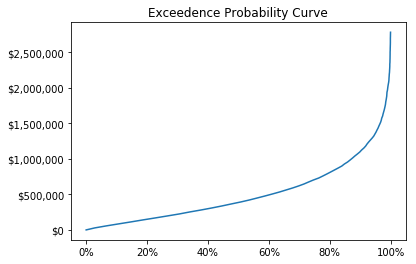

In [6]:

import scipy.stats as stats

import matplotlib.pyplot as plt

r = model1.export_results()
p = model1.export_params()

risk = r['Risk']
risk_min = risk.min()
risk_max = risk.max()

# Loss Exceedence Curbe
space = np.linspace(0, risk_max, 100)
series = pd.Series(space)
quantiles = series.map(lambda x: stats.percentileofscore(risk, x))
ax = plt.plot(quantiles, series)[0]

xax = ax.axes.xaxis
yax = ax.axes.yaxis

yax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
xax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))

ax.axes.set_title('Exceedence Probability Curve')

In [7]:
# For each point dollar amount, the probability it was exceeded
fbp = FairBetaPert(low=20_000_000, high=100_000_000, mode=23_000_000)
rand = fbp.random_variates(100_000)

space = np.linspace(0, rand.max(), 100)
series = pd.Series(space)
loss_ex = series.map(lambda value: (value < rand).mean())
ax = plt.plot(space, loss_ex * 100)[0]

xax = ax.axes.xaxis
yax = ax.axes.yaxis

xax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
yax.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}%'))

xax.set_tick_params(rotation=-45)
for tick in xax.get_major_ticks():
    tick.label.set_horizontalalignment('left')
    
ax.axes.set_title('Loss Exceedence Curve')

NameError: name 'FairBetaPert' is not defined

NameError: name 'colors' is not defined

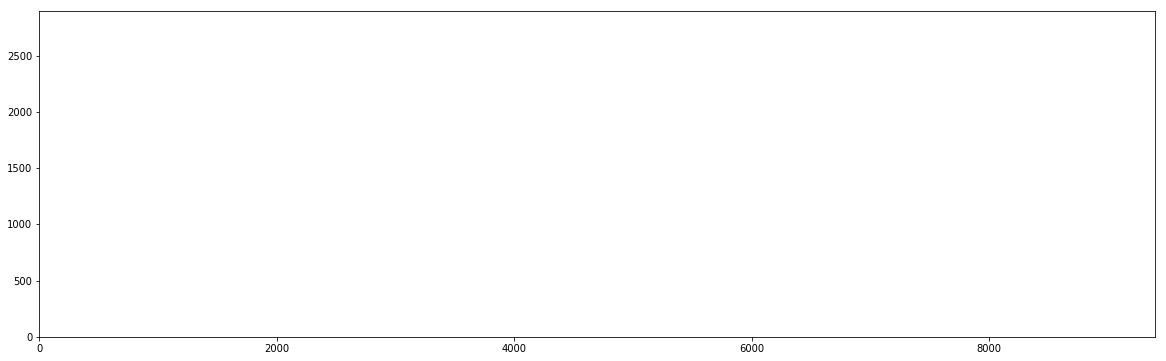

In [ ]:
model1 = pyfair.FairModel(name="HA", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model1.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model1.calculate_all()

model2 = pyfair.FairModel(name="NOT HA", n_simulations=10_000)
model2.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model2.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model2.calculate_all()


meta1 = pyfair.FairMetaModel('Metamodel', [model1, model2])
out_json = pyfair.FairMetaModel('Metamodel2', [model1, meta1])

In [ ]:
str(type(meta1))

In [ ]:
'''
FairModel
    Just one
FairAddititveMetaModel
    Add all the risks together and display with components
FairComparativeMetaModel
    Put risks side by side
    
Mu, Sigma for Risk

Model Params

Source
'''

In [ ]:
metadata = pd.Series(
    {
        'Author': os.environ['USERNAME'],
        'Generated': str(pd.datetime.now()).partition('.')[0],
        'PyFair Version': pyfair.VERSION
    }
).to_frame()

metadata

In [ ]:
#### Left third, provided data. RIght 2/3rds, tree
model2 = pyfair.read_json(results)
params = model2.export_params()
data = model2.export_results()
del params['Creation Datetime']
df = pd.DataFrame.from_dict(params)
df = df.reindex(['low', 'mode', 'high', 'p'])
df.index = df.index.str.title()
df

In [ ]:
derived = df.agg([np.mean, np.std, np.min, np.max])
derived.index = ['μ', 'σ', 'Minimum', 'Maximum']

final_data = pd.concat([derived, df], axis=0)
final_data = final_data.dropna()

# If Column as data greater than 1,
condition = final_data.max() > 1

# Get True Clumns
true_col = condition.loc[condition].index.values

#Get False COlumns
false_col = condition.loc[~condition].index.values

# If false, it's between 0 and 1. 3 decimals
final_data[false_col] = final_data[false_col]
final_data[false_col] = final_data[false_col].applymap(lambda x: '{0:.3f}'.format(x))

# If true, get the max digits and round
final_data[true_col] = final_data[true_col].astype(int)
final_data[true_col] = final_data[true_col].applymap(lambda x: '{0:,}'.format(x))

for column in ['Probable Loss Magnitude', 'Risk']:
    if column in final_data.columns:
        final_data[column] = '$' + final_data[column]

final_data.T

In [ ]:
model3 = pyfair.read_json(results)
df3 = model3.export_results()
risk = df3['Risk']
risk_d = risk.agg([np.mean, np.std, np.min, np.max]).astype(int)
risk_d.index = ['μ', 'σ', 'Minimum', 'Maximum']

pd.DataFrame(risk_d).T.applymap(lambda x: '${0:,}'.format(x))

In [ ]:
# Draw curves?
model3.__class__

SINGLE
    header
    meta
    left third, risk top then params. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code
    
COMPARISON
    header
    meta
    left third, risk top then params for each. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code

ADDITIVE
    header
    meta
    for each:
        left third, risk top then params. right 2/3, tree diagram
        left have loss excedence, right half exceedence probability
    for all:
        loss exceedence and exceedence probability and 
        risk
    code

In [ ]:
class FairBasic()

In [ ]:
uuid.uuid1()

In [ ]:
import os
import subprocess
import tempfile

td = tempfile.mkdtemp()
tf = tempfile.NamedTemporaryFile(dir=td, mode='w+')
os.chdir(td)

tf.write('LATEX!')

os.listdir(td)

p = subprocess.run(['dir', str(td)])

In [ ]:
model

In [ ]:
td